In [78]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class DCGAN(object):
    def __init__(self, input_shape=(28,28,1), latent_dim=100):
        self.latent_dim = latent_dim
        self.input_shape = input_shape
        
    def build_generator(self):
        inputs = Input(shape=(self.latent_dim,))
        
        x = Dense(7 * 7 * 16, use_bias=False)(inputs)
        x = Reshape(target_shape=(7, 7, 16))(x)
        
        ### Now shape = 14 x 14 x 32 ###
        x = Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x) 
        
        ### Now shape = 28 x 28 x 64 ###
        x = Conv2DTranspose(64, kernel_size=(3,3), strides=2, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
        ### Now shape = 28 x 28 x 1 ###
        x = Conv2DTranspose(1, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
        x = Activation("tanh")(x)
        
        generator = Model(inputs=inputs, outputs=x, name='generator')
        return generator
    
    def build_discriminator(self):
        inputs = Input(shape=self.input_shape)
        
        ### Now shape = 64 x 14 x 14 ###
        x = Conv2D(64, kernel_size=(3,3), strides=2, padding='same')(inputs)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        
        ### Now shape = 32 x 7 x 7 ###
        x = Conv2D(32, kernel_size=(3,3), strides=2, padding='same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        
        x = Flatten()(x)
        x = Dense(1)(x)
        
        discriminator = Model(inputs=inputs, outputs=x, name='discriminator')
        return discriminator     
        

In [81]:
### Training (On hand digit mnist ) ###
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.losses import BinaryCrossentropy

latent_dim = 100
epochs     = 100
batch_size = 64

g = DCGAN().build_generator()
d = DCGAN().build_discriminator()

if(os.path.exists('weights/g.weights.hdf5')):
    print('[*] Found weights file for generator ...')
    g.load_weights('weights/g.weights.hdf5')

if(os.path.exists('weights/d.weights.hdf5')):
    print('[*] Found weights file for discriminator ...')
    d.load_weights('weights/d.weights.hdf5')
    
g_opt = optimizers.Adam(1e-4)
d_opt = optimizers.Adam(1e-4)

print(g.summary())
print(d.summary())
bce = BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    labels = tf.ones(shape=(K.shape(fake_output)[0], 1))
    loss = bce(labels, fake_output)
    # loss = K.mean(loss)

    return loss

def discriminator_loss(real_output, fake_output):
    zeros = tf.zeros(shape=(K.shape(real_output)[0], 1))
    ones  = tf.ones(shape=(K.shape(real_output)[0], 1))
    
    real_loss = bce(ones, real_output)
    fake_loss = bce(zeros, fake_output)
    loss = real_loss + fake_loss
    # loss = K.mean(loss)
    
    return loss

@tf.function
def train_step(images):
    ### Calculating generator loss ###
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        noise = K.random_normal(shape=(K.shape(images)[0], latent_dim))
        generated_images = g(noise, training=True)

        fake_output = d(generated_images, training=True)
        real_output = d(images, training=True)
        
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)
        
    g_gradients = g_tape.gradient(g_loss, g.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, d.trainable_variables)
        
    g_opt.apply_gradients(zip(g_gradients, g.trainable_variables))
    d_opt.apply_gradients(zip(d_gradients, d.trainable_variables))
    
    return g_loss, d_loss
    
(X_train, _), (X_test, _) = mnist.load_data()

X_train = (X_train - 127.5) / 127.5
num_batches = X_train.shape[0] // batch_size
for i in range(epochs):
    ### Loop thru the batchs ###
    g_losses = []
    d_losses = []
    for j in range(num_batches):
        batch = X_train[j*batch_size:(j+1)*batch_size]
        g_loss, d_loss = train_step(batch)
        g_losses.append(g_loss)
        d_losses.append(d_loss)
    
    if(i % 15 == 0):
        g.save_weights('weights/g.weights.hdf5')
        d.save_weights('weights/d.weights.hdf5')
        
    print('Epochs number {} | generator loss = {}, discriminator loss = {}'.format(i+1, np.array(g_losses).mean(), np.array(d_losses).mean()))    
    
### Testing ...  ###
generator = DCGAN().build_generator()
generator.load_weights('weights/g.weights.hdf5')

latent_dim = 100
num_images = 100
grid_size = 10
noise = K.random_normal(shape=(num_images, latent_dim))
predictions = generator.predict(noise)
predictions = (predictions * 127.5 ) + 127.5
predictions = predictions.astype('uint8')

fig, ax = plt.subplots(grid_size, grid_size, figsize=(30,30))
for i in range(num_images):
    row = i // grid_size
    col = i % grid_size
    
    ax[row][col].imshow(predictions[i], cmap='Greys')

plt.show()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_135 (Dense)            (None, 784)               78400     
_________________________________________________________________
reshape_60 (Reshape)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_176 (Conv2D (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_172 (Bat (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_transpose_177 (Conv2D (None, 28, 28, 64)        18

Epochs number 52 | generator loss = 0.7886104583740234, discriminator loss = 1.3258646726608276
Epochs number 53 | generator loss = 0.787304699420929, discriminator loss = 1.3268420696258545
Epochs number 54 | generator loss = 0.789250910282135, discriminator loss = 1.328742504119873
Epochs number 55 | generator loss = 0.7843415141105652, discriminator loss = 1.327646017074585
Epochs number 56 | generator loss = 0.7852936387062073, discriminator loss = 1.3300946950912476
Epochs number 57 | generator loss = 0.786975622177124, discriminator loss = 1.3312779664993286
Epochs number 58 | generator loss = 0.7892782688140869, discriminator loss = 1.328514814376831
Epochs number 59 | generator loss = 0.7871024012565613, discriminator loss = 1.3287583589553833
Epochs number 60 | generator loss = 0.7854325771331787, discriminator loss = 1.3286464214324951
Epochs number 61 | generator loss = 0.7852028608322144, discriminator loss = 1.3281575441360474
Epochs number 62 | generator loss = 0.77967584

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_113 (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_140 (Dense)            (None, 784)               78400     
_________________________________________________________________
reshape_64 (Reshape)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_188 (Conv2D (None, 14, 14, 32)        4608      
_________________________________________________________________
batch_normalization_180 (Bat (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_156 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_transpose_189 (Conv2D (None, 28, 28, 64)        18

Epochs number 52 | generator loss = 0.9009772539138794, discriminator loss = 1.259559988975525
Epochs number 53 | generator loss = 0.849334180355072, discriminator loss = 1.28927481174469
Epochs number 54 | generator loss = 0.8219650983810425, discriminator loss = 1.3059628009796143
Epochs number 55 | generator loss = 0.8153778314590454, discriminator loss = 1.3082736730575562
Epochs number 56 | generator loss = 0.9282587170600891, discriminator loss = 1.239179253578186
Epochs number 57 | generator loss = 0.8519027233123779, discriminator loss = 1.3004975318908691
Epochs number 58 | generator loss = 0.8115642070770264, discriminator loss = 1.3136680126190186
Epochs number 59 | generator loss = 0.8078164458274841, discriminator loss = 1.314809799194336
Epochs number 60 | generator loss = 0.8079602122306824, discriminator loss = 1.3147886991500854
Epochs number 61 | generator loss = 0.8964648246765137, discriminator loss = 1.26621675491333
Epochs number 62 | generator loss = 0.8055188655

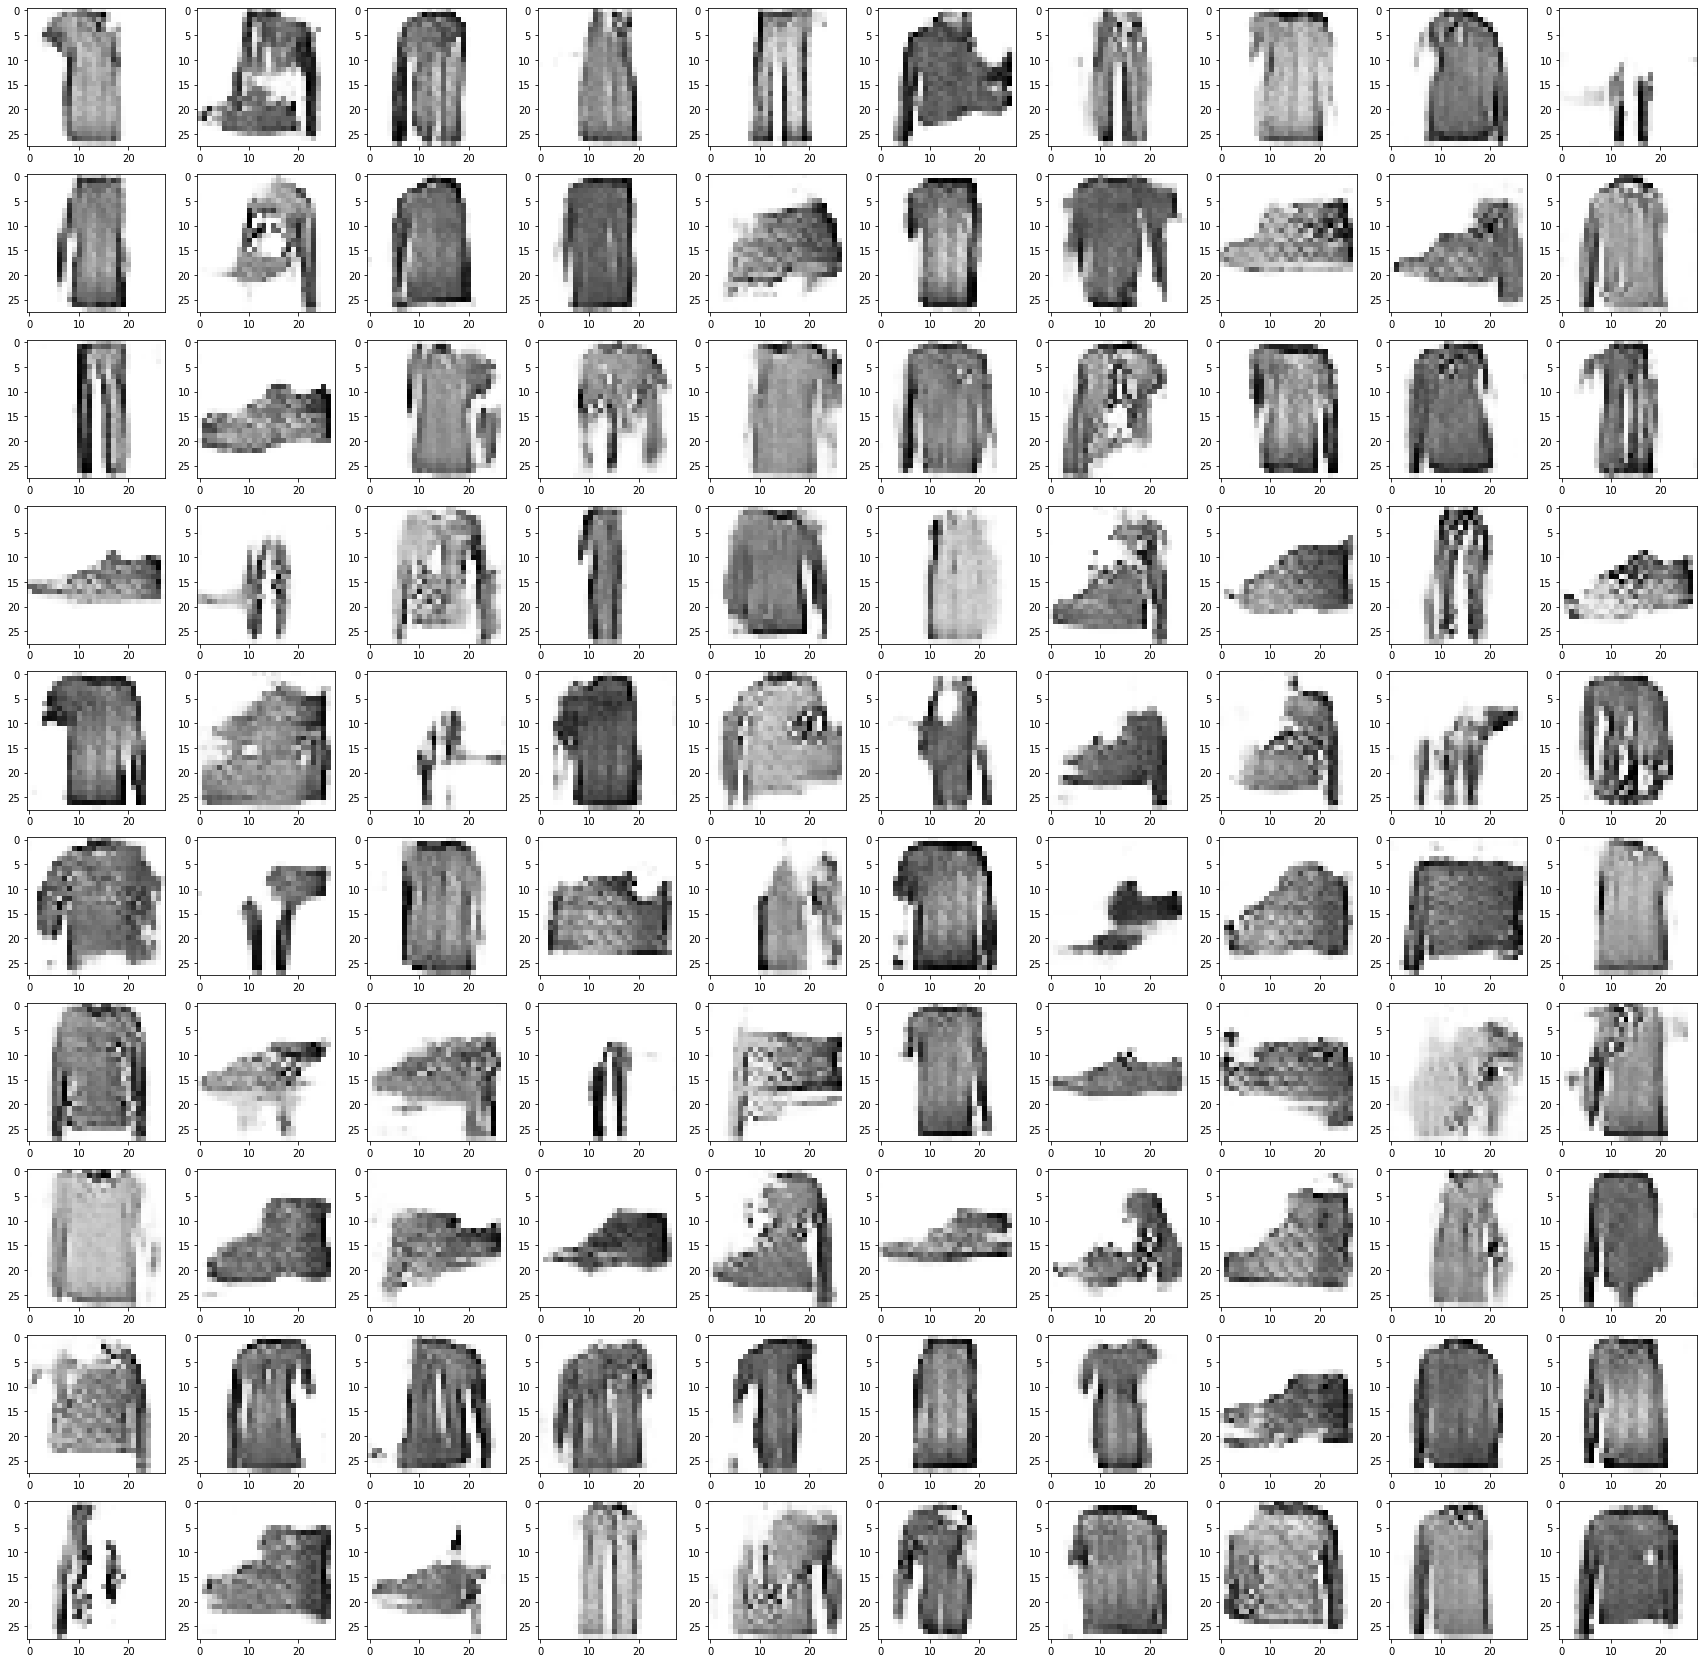

In [85]:
### Training (On fashion mnist ) ###
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.losses import BinaryCrossentropy

latent_dim = 100
epochs     = 100
batch_size = 64

g = DCGAN().build_generator()
d = DCGAN().build_discriminator()

if(os.path.exists('weights/g_fashion.weights.hdf5')):
    print('[*] Found weights file for generator ...')
    g.load_weights('weights/g_fashion.weights.hdf5')

if(os.path.exists('weights/d_fashion.weights.hdf5')):
    print('[*] Found weights file for discriminator ...')
    d.load_weights('weights/d_fashion.weights.hdf5')
    
g_opt = optimizers.Adam(1e-4)
d_opt = optimizers.Adam(1e-4)

print(g.summary())
print(d.summary())
bce = BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    labels = tf.ones(shape=(K.shape(fake_output)[0], 1))
    loss = bce(labels, fake_output)
    # loss = K.mean(loss)

    return loss

def discriminator_loss(real_output, fake_output):
    zeros = tf.zeros(shape=(K.shape(real_output)[0], 1))
    ones  = tf.ones(shape=(K.shape(real_output)[0], 1))
    
    real_loss = bce(ones, real_output)
    fake_loss = bce(zeros, fake_output)
    loss = real_loss + fake_loss
    # loss = K.mean(loss)
    
    return loss

@tf.function
def train_step(images):
    ### Calculating generator loss ###
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        noise = K.random_normal(shape=(K.shape(images)[0], latent_dim))
        generated_images = g(noise, training=True)

        fake_output = d(generated_images, training=True)
        real_output = d(images, training=True)
        
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)
        
    g_gradients = g_tape.gradient(g_loss, g.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, d.trainable_variables)
        
    g_opt.apply_gradients(zip(g_gradients, g.trainable_variables))
    d_opt.apply_gradients(zip(d_gradients, d.trainable_variables))
    
    return g_loss, d_loss
    
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = (X_train - 127.5) / 127.5
num_batches = X_train.shape[0] // batch_size
for i in range(epochs):
    ### Loop thru the batchs ###
    g_losses = []
    d_losses = []
    for j in range(num_batches):
        batch = X_train[j*batch_size:(j+1)*batch_size]
        g_loss, d_loss = train_step(batch)
        g_losses.append(g_loss)
        d_losses.append(d_loss)
    
    if(i % 15 == 0):
        g.save_weights('weights/g_fashion.weights.hdf5')
        d.save_weights('weights/d_fashion.weights.hdf5')
        
    print('Epochs number {} | generator loss = {}, discriminator loss = {}'.format(i+1, np.array(g_losses).mean(), np.array(d_losses).mean()))    
    
### Testing ...  ###
generator = DCGAN().build_generator()
generator.load_weights('weights/g_fashion.weights.hdf5')

latent_dim = 100
num_images = 100
grid_size = 10
noise = K.random_normal(shape=(num_images, latent_dim))
predictions = generator.predict(noise)
predictions = (predictions * 127.5 ) + 127.5
predictions = predictions.astype('uint8')

fig, ax = plt.subplots(grid_size, grid_size, figsize=(30,30))
for i in range(num_images):
    row = i // grid_size
    col = i % grid_size
    
    ax[row][col].imshow(predictions[i], cmap='Greys')

plt.show()